##### Load models and setup

In [ ]:
#@markdown <b>Load parameters</b><br/>   {display-mode: "form"}
params = {
    # Dataset parameters
    "dataset": "dataset_half_notrim_tensors",
    "train_split": 0.6,
    "val_split": 0.2,
    "test_split": 0.2,
}

In [ ]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
!pip install -q tensorflowjs
!pip install -q githubrelease
import numpy as np
import os, glob, re, time, json
import github_release
import tensorflow.keras.backend as K
from IPython import display
from contextlib import redirect_stdout

compressed_dirs = set()


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def _under(source_path, target_path, copy=True, auth_on_upload=True):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    if source_path.endswith("/"):
        source_path = source_path[:-1]
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    if source_islocal:
        source_path = os.path.abspath(source_path)
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Add forward slash if file is at root level
    source_dir = "/" if not source_dir else source_dir
    target_dir = "/" if not target_dir else target_dir

    # Authenticate if writing to GCS
    if target_isgcs and auth_on_upload:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !cp -r {source_path} {target_path}
            else:
                !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}

def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict
    

def _log_to_gh(user, repo, tag, log_dir="/tmp/logs"):
    # Create temporary directory for compressed logs
    !mkdir -p /tmp/compressed_logs
    
    # Compress all directories in log dir
    for dirname in os.listdir(log_dir):
        # Skip files
        if "." in dirname or dirname in compressed_dirs:
            continue

        # Compress
        _under(f"{log_dir}/{dirname}", f"/tmp/compressed_logs/{dirname}.tar.gz")
        compressed_dirs.add(dirname)

    # Upload compressed logs to GitHub
    github_release.gh_asset_upload(f"{user}/{repo}", tag, f"/tmp/compressed_logs/*.tar.gz")

    # Cleanup compressed logs
    !rm -rf /tmp/compressed_logs/*

def timeit(method):
    def timed(*args, **kw):
        ts = time.perf_counter()
        result = method(*args, **kw)
        te = time.perf_counter()
        diff = te - ts
        print(f"{method.__name__}: {diff:.8f} s")
        return result
    return timed

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

@timeit
def _export_model(model, model_name, model_type, val_dataset, test_dataset, params, hparams, history, log_dir, n_prep_layers=None):
    # Create temporary directory
    target_dir = f"/tmp/models/{model_type}/{model_name}"
    !mkdir -p {target_dir}     #/tmp_/models/rnn_naive/rnn_naive_20201108_130308

    # Write export logs to file
    export_logs_path = os.path.join(target_dir, "export_logs.txt")
    with open(export_logs_path, 'w') as export_logs:
        with redirect_stdout(export_logs):
            # Profile model on inputs (average of n_runs cycles)
            n_runs = 5
            input_shape = val_dataset.element_spec[0].shape

            def time_examples(model, n):
                dummy = np.random.rand(n, *input_shape[1:])
                t0 = time.perf_counter()
                model.predict(dummy)
                return time.perf_counter() - t0

            with tf.device('/CPU:0'):
                cpu_profiles = {
                    "cpu_1": np.array([time_examples(model, 1) for _ in range(n_runs)]).mean(),
                    "cpu_10": np.array([time_examples(model, 10) for _ in range(n_runs)]).mean(),
                    "cpu_100": np.array([time_examples(model, 100) for _ in range(n_runs)]).mean()
                }

            with tf.device('/GPU:0'):
                gpu_profiles = {
                    "gpu_1": np.array([time_examples(model, 1) for _ in range(n_runs)]).mean(),
                    "gpu_10": np.array([time_examples(model, 10) for _ in range(n_runs)]).mean(),
                    "gpu_100": np.array([time_examples(model, 100) for _ in range(n_runs)]).mean()
                }

            # Get number of parameters
            params_counts = {
                "trainable_params": np.sum([K.count_params(w) for w in model.trainable_weights]),
                "non_trainable_params": np.sum([K.count_params(w) for w in model.non_trainable_weights])
            }
            params_counts["total_params"] = params_counts["trainable_params"] + params_counts["non_trainable_params"]

            # Generate evaluation metrics for validation and test set
            final_metrics_val = model.evaluate(val_dataset, return_dict=True)
            final_metrics_val = {f"final_val_{k}": v for k, v in final_metrics_val.items()}
            final_metrics_test = model.evaluate(test_dataset, return_dict=True)
            final_metrics_test = {f"final_test_{k}": v for k, v in final_metrics_test.items()}

            # Generate Dataframe and export to parquet
            logs_params = {
                **params,
                **hparams,
                **history.params,
                **cpu_profiles,
                **gpu_profiles,
                **params_counts,
                **final_metrics_val,
                **final_metrics_test
            }
            logs_df = pd.DataFrame({**history.history, "epoch": history.epoch})
            for param, value in logs_params.items():
                logs_df[param] = value
            logs_df.to_parquet(os.path.join(target_dir, "logs.parquet"))

            # Dump all parameters and metadata to .json file
            with open(os.path.join(target_dir, 'model_details.json'), 'w') as f:
                json.dump(logs_params, f, cls=NpEncoder, indent=4)

            def _convert_model(model, subdir="model"):
                # Create subdirectory
                subdir_path = os.path.join(target_dir, subdir)
                !mkdir -p {subdir_path}

                # Write model summary to file
                model_summary_path = os.path.join(subdir_path, "model_summary.txt")
                with open(model_summary_path, 'w') as model_summary:
                    with redirect_stdout(model_summary):
                        model.summary()

                # Export model summary as image
                model_summary_img_path = os.path.join(subdir_path, "model_summary.png")
                tf.keras.utils.plot_model(model, to_file=model_summary_img_path, show_shapes=True)

                # Generate model paths
                keras_model_path = os.path.join(subdir_path, "keras_model.h5")
                saved_model_path = os.path.join(subdir_path, "saved_model")
                tfjs_layers_model_path = os.path.join(subdir_path, "tfjs_layers_model")
                tfjs_graph_model_path = os.path.join(subdir_path, "tfjs_graph_model")

                # Save and convert model
                model.save(keras_model_path)
                tf.saved_model.save(model, saved_model_path)
                !tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model {keras_model_path} {tfjs_layers_model_path}
                !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_path} {tfjs_graph_model_path}
            
            # Convert full model
            _convert_model(model, subdir="model")

            if n_prep_layers is not None:
                model_1 = tf.keras.Sequential(model.layers[:n_prep_layers])
                model_1.build(input_shape=input_shape)
                
                model_2 = tf.keras.Sequential(model.layers[n_prep_layers:])
                model_2.build(input_shape=model_1.layers[-1].output_shape)

                # Convert models
                _convert_model(model_1, subdir="submodel_1")
                _convert_model(model_2, subdir="submodel_2")

            # Compress TensorBoard logs
            model_log_dir = os.path.join(LOG_DIR, model_name)
            tensorboard_logs_path = os.path.join(target_dir, "tensorboard.tar.gz")
            _under(model_log_dir, tensorboard_logs_path)

    # Upload logs to GCS
    _under(target_dir, f"gs://marvin-voice/models/{model_type}/{model_name}", auth_on_upload=False)
    return logs_df

display.clear_output(wait=False)


In [ ]:
#@markdown <b>Imports</b><br/>   {display-mode: "form"}
# Download git repository
import os
if not os.getcwd().endswith("marvin-models"):
    !git config --global user.email "patrikkja@gmail.com"
    !git config --global user.name "Patrik Kjærran"
    !git clone -q https://github.com/patrikkj/marvin-models.git
    %cd marvin-models

# Internal modules
import io, sys, glob, time
from datetime import datetime
from importlib import reload

# External modules
!pip install -q pydub
!pip install -q tensorflow-io
#!pip install -q -U tensorboard_plugin_profile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorboard.plugins.hparams import api as hp

# Colab modules
from google.colab import auth
from IPython import display
    
# Scripts (record_audio requires pydub installed)
import scripts

display.clear_output(wait=False)

In [ ]:
#@markdown <b>Load models</b><br/>   {display-mode: "form"}
#rnn_path = "gs://marvin-voice/models/rnn_fft/rnn_fft_20201109_120328/model" best accuracy
#rnn_path = "gs://marvin-voice/models/rnn_fft/rnn_fft_20201110_184648/model"  newly created

# Old models
# rnn_path = "gs://marvin-voice/models/rnn_fft/rnn_fft_20201110_153920/model"
# rnn_naive_path = "gs://marvin-voice/models/rnn_naive/rnn_naive_20201109_052844/model"
# cnn_path = "gs://marvin-voice/models/cnn_fft/cnn_fft_20201109_064413/model"

# Final models    rnn_naive_20201115_034239             rnn_naive_20201115_034709
rnn_naive_path = "gs://marvin-voice/models/rnn_naive/rnn_naive_20201115_034239/model"
cnn_path = "gs://marvin-voice/models/cnn_fft/cnn_fft_20201111_063110/model"
rnn_path = "gs://marvin-voice/models/rnn_fft/rnn_fft_20201111_022641/model"

_under(rnn_naive_path, "/tmp/rnn_naive")
_under(cnn_path, "/tmp/cnn")
_under(rnn_path, "/tmp/rnn")

rnn_naive = tf.keras.models.load_model("/tmp/rnn_naive/saved_model")
cnn = tf.keras.models.load_model("/tmp/cnn/saved_model")
rnn = tf.keras.models.load_model("/tmp/rnn/saved_model")

display.clear_output(wait=False)

##### Load Dataset





In [ ]:
if 'arrays' not in globals():
    arrays = _from_gh("patrikkj", "marvin-models", params['dataset'])
    pos_data, pos_labels = arrays['pos_data'], arrays['pos_labels']
    neg_data, neg_labels = arrays['neg_data'], arrays['neg_labels']

In [ ]:
hparams = {
    'pos_weight': 0.5,
    'batch_size': 128,
}

# Dataset characteristics
classes = np.array([0, 1])
split = [params['train_split'], params['val_split'], params['test_split']]
split_array = np.array(split)

# Actual and desired class distributions
pos_size, neg_size = pos_labels.shape[0], neg_labels.shape[0]
pos_indices = np.ceil(split_array.cumsum() * pos_size).astype(int)
neg_indices = np.ceil(split_array.cumsum() * neg_size).astype(int)

# Stratified sampling to handle class imbalances
train_data_pos,  val_data_pos, test_data_pos = np.vsplit(pos_data, pos_indices[:-1])
train_data_neg,  val_data_neg, test_data_neg = np.vsplit(neg_data, neg_indices[:-1])

train_labels_pos,  val_labels_pos, test_labels_pos = np.split(pos_labels, pos_indices[:-1])
train_labels_neg,  val_labels_neg, test_labels_neg = np.split(neg_labels, neg_indices[:-1])

pos_data_shape = pos_data.shape
pos_labels_shape = pos_labels.shape
neg_data_shape = neg_data.shape
neg_labels_shape = neg_labels.shape

# Free up memory
pos_data, pos_labels = None, None
neg_data, neg_labels = None, None

# Constants
train_size = train_data_pos.shape[0] + train_data_neg.shape[0]
val_size = val_data_pos.shape[0] + val_data_neg.shape[0]
test_size = test_data_pos.shape[0] + test_data_neg.shape[0]

# Create training set (No rebalancing)
train_data = np.vstack((train_data_pos, train_data_neg))
train_labels = np.concatenate((train_labels_pos, train_labels_neg))
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(256)

# Create validation set
val_data = np.vstack((val_data_pos, val_data_neg))
val_labels = np.concatenate((val_labels_pos, val_labels_neg))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(256)

# Create test set
test_data = np.vstack((test_data_pos, test_data_neg))
test_labels = np.concatenate((test_labels_pos, test_labels_neg))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(256)

##### Dataset characteristics

In [ ]:
df = pd.DataFrame()

print(f"Positive data shape: {pos_data_shape}")
print(f"Positive labels shape: {pos_labels_shape}")
print(f"Negative data shape: {neg_data_shape}")
print(f"Negative labels shape: {neg_labels_shape}")

print(f"Train data positive shape: {train_data_pos.shape}")
print(f"Train data negative shape: {train_data_neg.shape}")

print(f"Val data positive shape: {val_data_pos.shape}")
print(f"Val data negative shape: {val_data_neg.shape}")

print(f"Test data positive shape: {test_data_pos.shape}")
print(f"Test data negative shape: {test_data_neg.shape}")

positive = pos_data_shape[0]
negative = neg_data_shape[0]
total = positive + negative
print(f"In total: {total}")
print(f"1 : {negative/positive}")

Positive data shape: (1746, 16000)
Positive labels shape: (1746,)
Negative data shape: (31488, 16000)
Negative labels shape: (31488,)
Train data positive shape: (1048, 16000)
Train data negative shape: (18893, 16000)
Val data positive shape: (349, 16000)
Val data negative shape: (6298, 16000)
Test data positive shape: (349, 16000)
Test data negative shape: (6297, 16000)
In total: 33234
1 : 18.034364261168385


##### Model results

In [ ]:
#@markdown <b>Run predictions</b><br/>   {display-mode: "form"}
# Run models on dataset to get predictions
timed_rnn_predict = timeit(rnn.predict)
rnn_train_pred = timed_rnn_predict(train_data)
rnn_val_pred = timed_rnn_predict(val_data)
rnn_test_pred = timed_rnn_predict(test_data)

timed_cnn_predict = timeit(cnn.predict)
cnn_train_pred = timed_cnn_predict(train_data)
cnn_val_pred = timed_cnn_predict(val_data)
cnn_test_pred = timed_cnn_predict(test_data)

timed_rnn_naive_predict = timeit(rnn_naive.predict)
rnn_naive_train_pred = timed_rnn_naive_predict(train_data)
rnn_naive_val_pred = timed_rnn_naive_predict(val_data)
rnn_naive_test_pred = timed_rnn_naive_predict(test_data)

predict: 12.74611584 s
predict: 1.27719512 s
predict: 1.25865458 s
predict: 1.99338561 s
predict: 0.63295814 s
predict: 0.66053329 s
predict: 11.74887522 s
predict: 3.50677253 s
predict: 3.52789186 s


In [ ]:
#@markdown <b>Generate metrics table</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
df = pd.DataFrame()

metrics = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      tf.keras.metrics.TruePositives(name='TP'),
      tf.keras.metrics.FalsePositives(name='FP'),
      tf.keras.metrics.TrueNegatives(name='TN'),
      tf.keras.metrics.FalseNegatives(name='FN'), 
      #tfa.metrics.F1Score(1, name="F1-score"),
]

for split in ('train', 'val', 'test'):
    for model in ('rnn', 'cnn', 'rnn_naive'):
        model_metrics = {"split": split, "model": model}
        for metric in metrics:
            pred = globals()[f"{model}_{split}_pred"]
            labels =  globals()[f"{split}_labels"]
            metric.reset_states()
            metric.update_state(labels, pred)
            value = metric.result().numpy()
            model_metrics[metric.name] = value
        df = df.append(model_metrics, ignore_index=True)
df.set_index(["split", "model"], inplace=True)
col_order = [metric.name for metric in metrics]
df = df.reindex(sorted(df.columns, key=lambda col: col_order.index(col)), axis=1)
df.to_latex("metrics_table.tex", 
            multirow=True, 
            caption="Evaluation metrics for all three models.", 
            float_format=lambda x: f"{x:.6f}" if np.mod(x, 1) else f"{int(x)}",
            bold_rows=True)
df

Accuracy  Precision    Recall  ...    FP       TN    FN
split model                                     ...                     
train rnn        0.999699   1.000000  0.994275  ...   0.0  18893.0   6.0
      cnn        0.999799   0.998092  0.998092  ...   2.0  18891.0   2.0
      rnn_naive  0.998897   0.997093  0.981870  ...   3.0  18890.0  19.0
val   rnn        0.998496   1.000000  0.971347  ...   0.0   6298.0  10.0
      cnn        0.996239   0.973684  0.954155  ...   9.0   6289.0  16.0
      rnn_naive  0.991575   0.950769  0.885387  ...  16.0   6282.0  40.0
test  rnn        0.998044   1.000000  0.962751  ...   0.0   6297.0  13.0
      cnn        0.996991   0.971347  0.971347  ...  10.0   6287.0  10.0
      rnn_naive  0.992477   0.960000  0.893983  ...  13.0   6284.0  37.0

[9 rows x 8 columns]

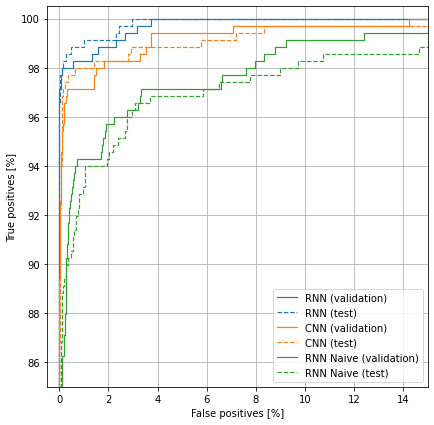

In [ ]:
#@title Plot ROC curve { vertical-output: true, output-height: 100, display-mode: "form" }
from sklearn import metrics as sk_metrics
plt.rcParams['figure.figsize'] = (7, 7)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sk_metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=1.2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,15])
    plt.ylim([85,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_roc("RNN (validation)", val_labels, rnn_val_pred, color=colors[0])
plot_roc("RNN (test)", test_labels, rnn_test_pred, color=colors[0], linestyle='--')

plot_roc("CNN (validation)", val_labels, cnn_val_pred, color=colors[1])
plot_roc("CNN (test)", test_labels, cnn_test_pred, color=colors[1], linestyle='--')

plot_roc("RNN Naive (validation)", val_labels, rnn_naive_val_pred, color=colors[2])
plot_roc("RNN Naive (test)", test_labels, rnn_naive_test_pred, color=colors[2], linestyle='--')

plt.legend(loc='lower right')
plt.savefig("roc_curve.png")


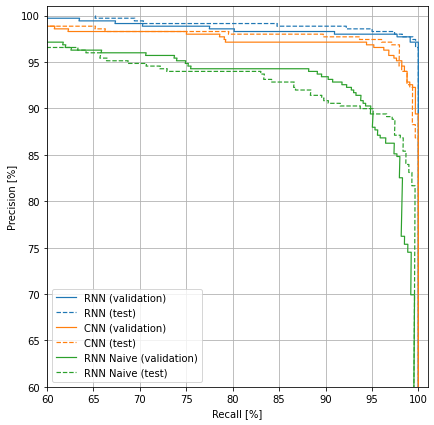

In [ ]:
#@title Plot PR Curve { vertical-output: true, output-height: 100, display-mode: "form" }
# Plot PR curve to illustrate precision/recall tradeoff
from sklearn import metrics as sk_metrics
plt.rcParams['figure.figsize'] = (7, 7)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_pr(name, labels, predictions, ax=None, **kwargs):
    pr, rec, _ = sk_metrics.precision_recall_curve(labels, predictions)
    plt.plot(100*pr, 100*rec, label=name, linewidth=1.2, **kwargs)
    plt.xlabel('Recall [%]')
    plt.ylabel('Precision [%]')
    plt.xlim([60,101])
    plt.ylim([60,101])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_pr("RNN (validation)", val_labels, rnn_val_pred, color=colors[0])
plot_pr("RNN (test)", test_labels, rnn_test_pred, color=colors[0], linestyle='--')

plot_pr("CNN (validation)", val_labels, cnn_val_pred, color=colors[1])
plot_pr("CNN (test)", test_labels, cnn_test_pred, color=colors[1], linestyle='--')

plot_pr("RNN Naive (validation)", val_labels, rnn_naive_val_pred, color=colors[2])
plot_pr("RNN Naive (test)", test_labels, rnn_naive_test_pred, color=colors[2], linestyle='--')

plt.legend(loc='lower left')
plt.savefig("pr_curve.png")

In [ ]:
#@markdown <b>Generate 'White noise' and 'LibriSpeech' datasets</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }

# Create white noise dataset
!pip install -q acoustics
from scipy.io import wavfile
import acoustics
path = "/tmp/white_noise_10min.wav"
wavfile.write(path, 16000, np.array(((acoustics.generator.noise(16000*60*10, color='white'))/3) * 32767).astype(np.int16))
raw_audio = tf.io.read_file(path)
white_noise, sample_rate = tf.audio.decode_wav(raw_audio)
white_noise = tf.squeeze(white_noise)

# Extract 10 minutes of audio from LibriSpeech Dataset
_under("gs://marvin-voice/data/test-clean.tar.gz", "/content/marvin-models/librispeech")
paths = np.array(glob.glob("/content/marvin-models/librispeech/**/*.flac", recursive=True))
p = np.random.permutation(len(paths))
paths = paths[p]
tensors = []
for path in paths[:100]:
    raw_audio = tf.io.read_file(path)
    tensor = tfio.audio.decode_flac(raw_audio, dtype=tf.int16)
    tensor = tf.cast(tensor, tf.float32)
    tensor /= 32768.0
    tensor = tensor.numpy().squeeze()
    tensors.append(tensor)

# Extract 10 minutes from the randomly permuted audio
librispeech_tensor = tf.concat(tensors, axis=0)[:16_000*60*10]

display.Audio(white_noise[:160_000], rate=16_000)

     |████████████████████████████████| 860kB 8.7MB/s 
	DOWNLOADING FILE    from    gs://marvin-voice/data/test-clean.tar.gz    to    /tmp_/test-clean.tar.gz
EXTRACTING (1/1)    from    /tmp_/test-clean.tar.gz    to    /content/marvin-models/librispeech


In [ ]:
#@markdown <b>Generate 200ms sliding window datasets for inference</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }

def gen_white_noise_dataset(batch_size):
    path = "/tmp/white_noise_10min.wav"
    wavfile.write(path, 16000, np.array(((acoustics.generator.noise(16000*60*10, color='white'))/3) * 32767).astype(np.int16))
    raw_audio = tf.io.read_file(path)
    white_noise, sample_rate = tf.audio.decode_wav(raw_audio)
    white_noise = tf.squeeze(white_noise)

    white_noise_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        white_noise, None, 16_000, sequence_stride=16_000//5, sampling_rate=1,
        batch_size=batch_size)
    return white_noise_dataset

def gen_libri_speech_dataset(batch_size):
    paths = np.array(glob.glob("/content/marvin-models/librispeech/**/*.flac", recursive=True))
    p = np.random.permutation(len(paths))
    paths = paths[p]
    tensors = []
    for path in paths[:100]:
        raw_audio = tf.io.read_file(path)
        tensor = tfio.audio.decode_flac(raw_audio, dtype=tf.int16)
        tensor = tf.cast(tensor, tf.float32)
        tensor /= 32768.0
        tensor = tensor.numpy().squeeze()
        tensors.append(tensor)
    librispeech_tensor = tf.concat(tensors, axis=0)[:16_000*60*10]

    libri_speech_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        librispeech_tensor, None, 16_000, sequence_stride=16_000//5, sampling_rate=1,
        batch_size=batch_size)
    return libri_speech_dataset

In [ ]:
#@markdown <b>Build table for computational footprint and false positive rates</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }

df = pd.DataFrame()

models = [
    ("RNN (Naive)", rnn_naive),
    ("CNN", cnn),
    ("RNN", rnn),
]

datasets = [
    ("White noise", gen_white_noise_dataset),
    ("LibriSpeech", gen_libri_speech_dataset),
]

for name, model in models:
    model_results = {"model": name}
    for name, dataset_gen in datasets:
        for batch_size in (1, 32, 256):
            dataset = dataset_gen(batch_size)
            model_results[f"Num. windows"] = len(list(_ for _ in dataset.unbatch()))

            ts = time.perf_counter()
            num_triggers = (timeit(model.predict)(dataset) > 0.5).sum()
            te = time.perf_counter()
            diff = te - ts
            model_results[name] = num_triggers
            model_results[f"Inference time (Batch size: {batch_size})"] = diff
            model_results[f"Inference time/ex [ms] (Batch size: {batch_size})"] = 1000*diff/model_results[f"Num. windows"]


    df = df.append(model_results, ignore_index=True)

df.set_index("model", inplace=True)
other_df = df[["White noise", "LibriSpeech"]]
other_df.to_latex("other_datasets.tex", 
            multirow=True, 
            caption="Evaluation of false triggers.", 
            float_format=lambda x: f"{x:.3f}" if np.mod(x, 1) else f"{int(x)}",
            bold_rows=True)

comp_df = df[['Inference time (Batch size: 1)',
               'Inference time/ex [ms] (Batch size: 1)', 
               'Inference time (Batch size: 32)',
               'Inference time/ex [ms] (Batch size: 32)', 
               'Inference time (Batch size: 256)',
               'Inference time/ex [ms] (Batch size: 256)',
       'Num. windows']]
comp_df.to_latex("computational_footprint.tex", 
            multirow=True, 
            caption="Evaluation of computational footprint.", 
            float_format=lambda x: f"{x:.3f}" if np.mod(x, 1) else f"{int(x)}",
            bold_rows=True)

other_df

predict: 43.28076255 s
predict: 1.92190853 s
predict: 0.75295918 s
predict: 42.81883163 s
predict: 1.88905466 s
predict: 0.72757312 s
predict: 7.18568283 s
predict: 0.69548519 s
predict: 0.57923304 s
predict: 6.84411203 s
predict: 0.72034414 s
predict: 0.55891580 s
predict: 14.55802426 s
predict: 0.87947942 s
predict: 0.59303478 s
predict: 14.64775656 s
predict: 0.85358308 s
predict: 0.57935646 s


,White noise,LibriSpeech
model,,
RNN (Naive),3.0,53.0
CNN,0.0,46.0
RNN,0.0,27.0


In [ ]:
df.columns

Index(['Inference time (Batch size: 256)', 'Inference time (Batch size: 32)',
       'Inference time/ex (Batch size: 256)',
       'Inference time/ex (Batch size: 32)', 'LibriSpeech', 'Num. windows',
       'White noise'],
      dtype='object')

In [ ]:
#@markdown <b>Fetch GPU details</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
!nvidia-smi

Sun Nov 15 02:00:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   9631MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
for row in white_noise_dataset.take(1):
    print(row)

tf.Tensor(
[[ 0.32305908 -0.2961731  -0.3288269  ... -0.02972412 -0.46777344
   0.44299316]
 [-0.04272461  0.09387207 -0.10217285 ...  0.28546143  0.3295288
   0.07022095]
 [-0.48034668 -0.0123291  -0.4841919  ...  0.4382019   0.06390381
  -0.23641968]
 ...
 [-0.3201599  -0.09979248  0.18218994 ...  0.21105957  0.00180054
   0.05975342]
 [-0.5800476  -0.4701233  -0.5336609  ... -0.47143555  0.2685547
   0.18139648]
 [-0.17996216 -0.23110962 -0.00973511 ... -0.79577637  0.16894531
   0.05133057]], shape=(32, 16000), dtype=float32)


In [ ]:
display.Audio(librispeech_tensor, rate=16_000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(f"Number of false triggers (RNN): {(timeit(rnn.predict)(libri_speech_dataset) > 0.5).sum()}")
print(f"Number of false triggers (CNN): {(timeit(cnn.predict)(libri_speech_dataset) > 0.5).sum()}")
print(f"Number of false triggers (RNN Naive): {(timeit(rnn_naive.predict)(libri_speech_dataset) > 0.5).sum()}")